In [48]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [2]:
sp500_futures = pd.read_csv("../data/sp500_futures_tick_data.csv")
sp500_futures.head()

,date,time,price,volume
0,01/03/2000,08:30:34.000,1496.4,0
1,01/03/2000,08:30:36.000,1496.0,0
2,01/03/2000,08:30:37.000,1495.5,0
3,01/03/2000,08:30:46.000,1495.0,0
4,01/03/2000,08:30:53.000,1495.5,0


In [3]:
print(sp500_futures.date.min())
print(sp500_futures.date.max())

01/01/2015
12/31/2019


## 0. Add SP500 spot price

Join the price of sp500 to sp500_futures with matching date

In [4]:
sp500_original = pd.read_csv('../data/sp500.csv')
# The time is always "00:00:00"
sp500 = pd.DataFrame()
# Remove the time, which is always 00:00:00
sp500['date'] = sp500_original.Date.str.replace("00:00:00", "").str.strip()
# Change date format to match with dates from sp500_futures
sp500['date'] = pd.to_datetime(sp500['date']).dt.strftime('%m/%d/%Y')
# Set the price using the adjusted close
sp500['price'] = sp500_original['Adj Close']

del sp500_original

sp500.head()

,date,price
0,01/03/1950,16.66
1,01/04/1950,16.85
2,01/05/1950,16.93
3,01/06/1950,16.98
4,01/09/1950,17.08


In [5]:
sp500_futures = pd.merge(sp500_futures, sp500, on='date') # inner join by default
sp500_futures.rename(columns={'price_x': 'price', 'price_y': 'spot_price'}, inplace=True)
sp500_futures.head()

,date,time,price,volume,spot_price
0,01/03/2000,08:30:34.000,1496.4,0,1455.22
1,01/03/2000,08:30:36.000,1496.0,0,1455.22
2,01/03/2000,08:30:37.000,1495.5,0,1455.22
3,01/03/2000,08:30:46.000,1495.0,0,1455.22
4,01/03/2000,08:30:53.000,1495.5,0,1455.22


## 1. Standard bars

### Convert time bars to tick bars

Note: Pick timestamp when the information was fully available to avoid look-ahead effects

Collect all time bars for each day
Get the bars for every tick count: date, time, bar_count, open, close, high, low, total_volume, complete

1. Is there any pre-hour and post-hour trading activities?
Yes, find the min and max of column 'time'

2. How to handle incomplete tick bars?
Answer: Keep the count of time bars, and add a column named 'complete' to mark if the tick bar is complete or not

3. Should I cutoff tick bars for each day? How to handle overnight trading?
Answer: For now, let's consider each day from 00:00 to 23:59 as a whole trading day

In [6]:
tick_size = 1000
grouped_by_date = sp500_futures.groupby('date')
# Within each date group, dividing further into each sub-group of `tick_size' rows
sp500_futures['group_in_date'] = grouped_by_date.cumcount() // tick_size

In [7]:
def aggregate_bars(x):
    d = {}
    d['date'] = x['date'].iloc[-1]
    d['time'] = x['time'].iloc[-1]
    d['open'] = x['price'].iloc[0]
    d['close'] = x['price'].iloc[-1]
    d['low'] = x['price'].min()
    d['high'] = x['price'].max()
    d['spot_price'] = x['spot_price'].iloc[-1] # match with the last date
    d['total_volume'] = x['volume'].sum()
    # In edge case, d['total_volume'] can be 0 if all volume in the df is 0
    d['vol_weighted_avg_price'] = x['price'].dot(x['volume']) / d['total_volume'] if d['total_volume'] else 0
    d['count'] = x['date'].count()
    return pd.Series(d)

In [8]:
sp500_futures_ticks = sp500_futures.groupby(['date', 'group_in_date'], as_index=False).apply(aggregate_bars)
sp500_futures_ticks['complete'] = sp500_futures_ticks['count'] == tick_size
sp500_futures_ticks.head()

,group_in_date,date,time,open,close,low,high,spot_price,total_volume,vol_weighted_avg_price,count,complete
0,0,01/02/2001,10:30:40.000,1330.0,1312.5,1307.5,1334.8,1283.27,0,0.0,1000,True
1,1,01/02/2001,12:46:56.000,1312.4,1307.0,1305.0,1315.0,1283.27,0,0.0,1000,True
2,2,01/02/2001,14:55:41.000,1307.0,1291.5,1289.0,1309.5,1283.27,0,0.0,1000,True
3,3,01/02/2001,15:14:36.000,1291.0,1299.4,1291.0,1301.0,1283.27,0,0.0,151,False
4,0,01/02/2002,10:08:00.000,1150.0,1141.2,1136.5,1150.5,1154.67,0,0.0,1000,True


### Convert time bars to volume bars

In [9]:
volume_size = 1000
sp500_futures['volume_group'] = sp500_futures.volume.cumsum() // volume_size

In [10]:
sp500_futures_volumes = sp500_futures.groupby('volume_group', as_index=False).apply(aggregate_bars)
sp500_futures_volumes.head()

,volume_group,date,time,open,close,low,high,spot_price,total_volume,vol_weighted_avg_price,count
0,0,07/01/2003,03:13:12.000,1496.4,971.8,767.5,1574.0,982.32,997,973.188365,2813357
1,1,07/01/2003,06:27:39.000,971.9,971.1,971.1,973.2,982.32,999,972.021121,524
2,2,07/01/2003,07:43:08.000,971.3,968.3,967.6,972.0,982.32,1003,970.340678,451
3,3,07/01/2003,15:56:37.000,968.0,981.6,960.5,982.4,982.32,1000,969.736700,3448
4,4,07/02/2003,01:26:16.000,981.7,982.5,981.3,984.0,993.75,999,982.660761,416


### Convert time bars to dollar bars

In [11]:
dollar_size = 1000000
sp500_futures['dollar'] = sp500_futures.price * sp500_futures.volume
sp500_futures['dollar_group'] = sp500_futures['dollar'].cumsum().astype(int) // dollar_size
sp500_futures.head()

,date,time,price,volume,spot_price,group_in_date,volume_group,dollar,dollar_group
0,01/03/2000,08:30:34.000,1496.4,0,1455.22,0,0,0.0,0
1,01/03/2000,08:30:36.000,1496.0,0,1455.22,0,0,0.0,0
2,01/03/2000,08:30:37.000,1495.5,0,1455.22,0,0,0.0,0
3,01/03/2000,08:30:46.000,1495.0,0,1455.22,0,0,0.0,0
4,01/03/2000,08:30:53.000,1495.5,0,1455.22,0,0,0.0,0


In [12]:
def aggregate_dollar_bars(x):
    d = {}
    d['date'] = x['date'].iloc[-1]
    d['time'] = x['time'].iloc[-1]
    d['open'] = x['price'].iloc[0]
    d['close'] = x['price'].iloc[-1]
    d['low'] = x['price'].min()
    d['high'] = x['price'].max()
    d['spot_price'] = x['spot_price'].iloc[-1]
    d['total_volume'] = x['volume'].sum()
    # In edge case, d['total_volume'] can be 0 if all volume in the df is 0
    d['vol_weighted_avg_price'] = x['price'].dot(x['volume']) / d['total_volume'] if d['total_volume'] else 0
    d['dollar'] = x['dollar'].sum()
    d['count'] = x['date'].count()
    return pd.Series(d)

In [13]:
sp500_futures_dollar = sp500_futures.groupby('dollar_group', as_index=False).apply(aggregate_dollar_bars)
sp500_futures_dollar.head()

,dollar_group,date,time,open,close,low,high,spot_price,total_volume,vol_weighted_avg_price,dollar,count
0,0,07/01/2003,03:16:30.000,1496.4,971.8,767.5,1574.0,982.32,1027,973.153262,999428.4,2813371
1,1,07/01/2003,06:32:03.000,971.9,971.3,971.1,973.2,982.32,1029,971.973761,1000161.0,532
2,2,07/01/2003,07:44:30.000,971.3,968.2,967.6,972.0,982.32,1021,970.135260,990508.1,468
3,3,07/01/2003,16:22:22.000,968.1,982.4,960.5,982.4,982.32,1039,971.218479,1009096.0,3447
4,4,07/02/2003,01:51:04.000,982.2,983.1,981.3,984.0,993.75,1017,982.785251,999492.6,428


## 2. Information-driven bars (TODO later)

In [14]:
sp500_futures['next_price'] = sp500_futures.price.shift(-1)

In [15]:
sp500_futures['delta_p'] = sp500_futures.next_price - sp500_futures.price
sp500_futures.dropna(inplace=True)

# Initialize to 0s
sp500_futures['tick_b_t'] = np.where(sp500_futures['delta_p'] == 0, 0, np.sign(sp500_futures['delta_p']))
sp500_futures.head()

,date,time,price,volume,spot_price,group_in_date,volume_group,dollar,dollar_group,next_price,delta_p,tick_b_t
0,01/03/2000,08:30:34.000,1496.4,0,1455.22,0,0,0.0,0,1496.0,-0.4,-1.0
1,01/03/2000,08:30:36.000,1496.0,0,1455.22,0,0,0.0,0,1495.5,-0.5,-1.0
2,01/03/2000,08:30:37.000,1495.5,0,1455.22,0,0,0.0,0,1495.0,-0.5,-1.0
3,01/03/2000,08:30:46.000,1495.0,0,1455.22,0,0,0.0,0,1495.5,0.5,1.0
4,01/03/2000,08:30:53.000,1495.5,0,1455.22,0,0,0.0,0,1495.0,-0.5,-1.0


## 3. ETF Rolling (TODO later)

In [16]:
import nasdaqdatalink

## 4. Plot the number of ticks per week

In [17]:
sp500_futures_ticks['date'] = pd.to_datetime(sp500_futures_ticks['date'])
weekly_tick_bars_count = sp500_futures_ticks.groupby([pd.Grouper(key='date', freq='W')])['date'].count()
weekly_tick_bars_count.head()

date
2000-01-09    24
2000-01-16    24
2000-01-23    20
2000-01-30    23
2000-02-06    21
Freq: W-SUN, Name: date, dtype: int64

<Axes: xlabel='date'>

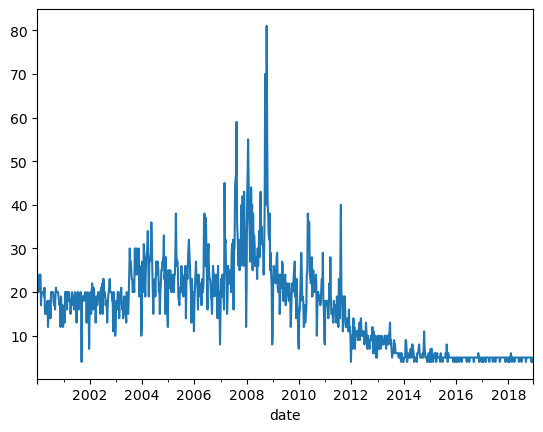

In [18]:
weekly_tick_bars_count.plot()

In [19]:
sp500_futures_volumes['date'] = pd.to_datetime(sp500_futures_volumes['date'])
weekly_volume_bars_count = sp500_futures_volumes.groupby([pd.Grouper(key='date', freq='W')])['date'].count()
weekly_volume_bars_count.head()

date
2003-07-06    14
2003-07-13    27
2003-07-20    28
2003-07-27    22
2003-08-03    21
Freq: W-SUN, Name: date, dtype: int64

<Axes: xlabel='date'>

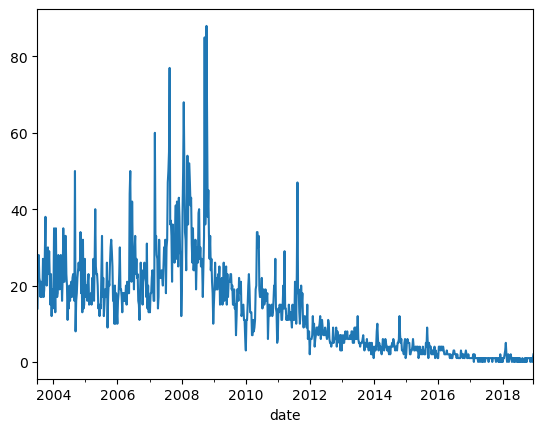

In [20]:
weekly_volume_bars_count.plot()

In [21]:
sp500_futures_dollar['date'] = pd.to_datetime(sp500_futures_dollar['date'])
weekly_dollar_bars_count = sp500_futures_dollar.groupby([pd.Grouper(key='date', freq='W')])['date'].count()
weekly_dollar_bars_count.head()

date
2003-07-06    14
2003-07-13    26
2003-07-20    29
2003-07-27    21
2003-08-03    21
Freq: W-SUN, Name: date, dtype: int64

<Axes: xlabel='date'>

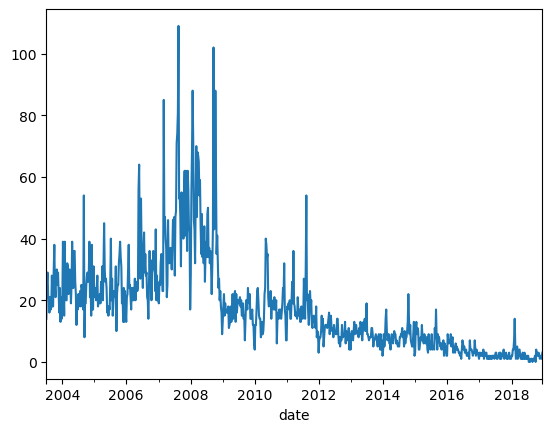

In [22]:
weekly_dollar_bars_count.plot()

## 5. Compute serial correlation for each type of ticks data

In [32]:
# sp500_futures_ticks.head()
sp500_futures_ticks[['open', 'close', 'high', 'total_volume', 'vol_weighted_avg_price']].apply(lambda x: x.autocorr(lag=1))

open                      0.751639
close                     0.751922
high                      0.752154
total_volume              0.264479
vol_weighted_avg_price    0.516623
dtype: float64

In [35]:
# sp500_futures_volumes.head()
sp500_futures_volumes[['open', 'close', 'high', 'total_volume', 'vol_weighted_avg_price']].apply(lambda x: x.autocorr(lag=1))

open                      0.999227
close                     0.999395
high                      0.999193
total_volume              0.159656
vol_weighted_avg_price    0.999593
dtype: float64

In [36]:
sp500_futures_dollar[['open', 'close', 'high', 'total_volume', 'vol_weighted_avg_price']].apply(lambda x: x.autocorr(lag=1))

open                      0.999525
close                     0.999627
high                      0.999491
total_volume              0.713937
vol_weighted_avg_price    0.999741
dtype: float64

## 6. Compute the variance of returns for each month, then the variance of variances for each tick type

In [43]:
sp500_futures_ticks['intraday_simple_return'] = (sp500_futures_ticks.close - sp500_futures_ticks.open) / sp500_futures_ticks.open * 100
sp500_futures_ticks['intraday_log_return'] = np.log(sp500_futures_ticks.close / sp500_futures_ticks.open)
sp500_futures_ticks.groupby(pd.Grouper(key='date', freq='M'))[['intraday_simple_return', 'intraday_log_return']].var().var()

intraday_simple_return    2.599631e-01
intraday_log_return       2.634342e-09
dtype: float64

In [44]:
sp500_futures_volumes['intraday_simple_return'] = (sp500_futures_volumes.close - sp500_futures_volumes.open) / sp500_futures_volumes.open * 100
sp500_futures_volumes['intraday_log_return'] = np.log(sp500_futures_volumes.close / sp500_futures_volumes.open)
sp500_futures_volumes.groupby(pd.Grouper(key='date', freq='M'))[['intraday_simple_return', 'intraday_log_return']].var().var()

intraday_simple_return    2.747870e+00
intraday_log_return       3.720673e-08
dtype: float64

In [45]:
sp500_futures_dollar['intraday_simple_return'] = (sp500_futures_dollar.close - sp500_futures_dollar.open) / sp500_futures_dollar.open * 100
sp500_futures_dollar['intraday_log_return'] = np.log(sp500_futures_dollar.close / sp500_futures_dollar.open)
sp500_futures_dollar.groupby(pd.Grouper(key='date', freq='M'))[['intraday_simple_return', 'intraday_log_return']].var().var()

intraday_simple_return    1.208934e+00
intraday_log_return       2.157367e-08
dtype: float64

In [53]:
# Reject the Normal hypothesis if pvalue < 0.05
print(stats.jarque_bera(sp500_futures_ticks['intraday_simple_return']))
print(stats.jarque_bera(sp500_futures_ticks['intraday_log_return']))

SignificanceResult(statistic=80733.99094541131, pvalue=0.0)
SignificanceResult(statistic=78485.75949911484, pvalue=0.0)


In [55]:
print(stats.jarque_bera(sp500_futures_volumes['intraday_simple_return']))
print(stats.jarque_bera(sp500_futures_volumes['intraday_log_return']))

SignificanceResult(statistic=87956379.73192804, pvalue=0.0)
SignificanceResult(statistic=298896556.46587044, pvalue=0.0)


In [56]:
# Reject the Normal hypothesis if pvalue < 0.05
print(stats.jarque_bera(sp500_futures_dollar['intraday_simple_return']))
print(stats.jarque_bera(sp500_futures_dollar['intraday_log_return']))

SignificanceResult(statistic=178698336.5605066, pvalue=0.0)
SignificanceResult(statistic=613249992.0520062, pvalue=0.0)


## Bollinger band